In [2]:
import os, sys

import numpy as np
import pandas as pd
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from scipy.optimize import curve_fit
from datetime import datetime, timedelta

import xgboost as xgb
from xgboost import XGBRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from matplotlib import pyplot as plt
import seaborn as sns

import pickle as pkl
from scipy.io import loadmat
from astropy.time import Time
from astropy.coordinates import get_sun

In [3]:
sw_df1 = pd.read_csv('../data/bdt_training/combined_density_sw_merged_1303_1403_addomni_goes_vars.csv')
sw_df2 = pd.read_csv('../data/bdt_training/combined_density_sw_merged_1704_addomni_goes_vars.csv')
sw_df3 = pd.read_csv('../data/bdt_training/combined_density_sw_merged_1004_addomni_goes_vars.csv')

In [4]:
df = pd.concat((sw_df1, sw_df2, sw_df3))

# Convert 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [5]:
df.columns

Index(['time', 'density_orbitmean', 'density', 'altitude', 'longitude',
       'latitude', 'min_ap_index_nT', 'max_ap_index_nT', 'average_ap_index_nT',
       'std_ap_index_nT', 'min_f10.7_index', 'max_f10.7_index',
       'average_f10.7_index', 'std_f10.7_index', 'min_Lyman_alpha',
       'max_Lyman_alpha', 'average_Lyman_alpha', 'std_Lyman_alpha',
       'min_Dst_index_nT', 'max_Dst_index_nT', 'average_Dst_index_nT',
       'std_Dst_index_nT', 'min_Lyman_alpha2', 'max_Lyman_alpha2',
       'average_Lyman_alpha2', 'std_Lyman_alpha2', 'min_f10.7_index2',
       'max_f10.7_index2', 'average_f10.7_index2', 'std_f10.7_index2',
       'min_Lyman_alpha_f10.7', 'max_Lyman_alpha_f10.7',
       'average_Lyman_alpha_f10.7', 'std_Lyman_alpha_f10.7',
       'min_ap_index_nT2', 'max_ap_index_nT2', 'average_ap_index_nT2',
       'std_ap_index_nT2', 'min_ap_index_nT_f10.7', 'max_ap_index_nT_f10.7',
       'average_ap_index_nT_f10.7', 'std_ap_index_nT_f10.7', 'min_xrsb_flux',
       'max_xrsb_flux', 

In [6]:
features = []

proxy_prefix = ['average', 'min', 'max']
proxy_vars = ['ap_index_nT', 'f10.7_index', 'Lyman_alpha', 'Dst_index_nT', 'Lyman_alpha2',
              'f10.7_index2', 'Lyman_alpha_f10.7', 'ap_index_nT2', 'ap_index_nT_f10.7' ]

df = df[((df['altitude']<2e3) & (df['latitude']<180) & (df['longitude']<360) & (df.density_orbitmean<1.0))]

for p in proxy_prefix:
    for f in proxy_vars:
        varname = '{}_{}'.format(p, f)
        features.append(varname)
features = features + ['altitude']
df = df[features + ['density_orbitmean']]

In [7]:
print(features)

['average_ap_index_nT', 'average_f10.7_index', 'average_Lyman_alpha', 'average_Dst_index_nT', 'average_Lyman_alpha2', 'average_f10.7_index2', 'average_Lyman_alpha_f10.7', 'average_ap_index_nT2', 'average_ap_index_nT_f10.7', 'min_ap_index_nT', 'min_f10.7_index', 'min_Lyman_alpha', 'min_Dst_index_nT', 'min_Lyman_alpha2', 'min_f10.7_index2', 'min_Lyman_alpha_f10.7', 'min_ap_index_nT2', 'min_ap_index_nT_f10.7', 'max_ap_index_nT', 'max_f10.7_index', 'max_Lyman_alpha', 'max_Dst_index_nT', 'max_Lyman_alpha2', 'max_f10.7_index2', 'max_Lyman_alpha_f10.7', 'max_ap_index_nT2', 'max_ap_index_nT_f10.7', 'altitude']


In [8]:
col_ranges = {
    'altitude': (0, 1000),
    
    'average_ap_index_nT': (0,400),
    'average_f10.7_index': (63.4,250),
    'average_Lyman_alpha': (0.00588,0.010944),
    'average_Dst_index_nT': (-422,71),
    'average_Lyman_alpha2': (0, 1e-4),
    'average_f10.7_index2': (3969, 62500),
    'average_Lyman_alpha_f10.7': (0, 2.75),
    'average_ap_index_nT2': (0, 1.6e5),
    'average_ap_index_nT_f10.7': (0, 1e5),

    'min_ap_index_nT': (0,400),
    'min_f10.7_index': (63.4,250),
    'min_Lyman_alpha': (0.00588,0.010944),
    'min_Dst_index_nT': (-422,71),
    'min_Lyman_alpha2': (0, 1e-4),
    'min_f10.7_index2': (3969, 62500),
    'min_Lyman_alpha_f10.7': (0, 2.75),
    'min_ap_index_nT2': (0, 1.6e5),
    'min_ap_index_nT_f10.7': (0, 1e5),

    'max_ap_index_nT': (0,400),
    'max_f10.7_index': (63.4,250),
    'max_Lyman_alpha': (0.00588,0.010944),
    'max_Dst_index_nT': (-422,71),
    'max_Lyman_alpha2': (0, 1e-4),
    'max_f10.7_index2': (3969, 62500),
    'max_Lyman_alpha_f10.7': (0, 2.75),
    'max_ap_index_nT2': (0, 1.6e5),
    'max_ap_index_nT_f10.7': (0, 1e5),
}

In [9]:
# transform the input features
for col_ in col_ranges:
    min_, max_ = col_ranges[col_]
    df[col_] = (df[col_]-min_)/(max_-min_)

The residuals have slight correlations with the F10 values, whereas, they don't seem to be correlated with the other spatial or temporal parameters.

In [10]:
print(len(df))
alt_bins = np.arange(200, 620, 70)
size = len(df)
solar_act_bins = [0, 0.25, 0.5, 1.0]

for i in range(len(alt_bins)-1):
    alt_filter = (df['altitude']*1e3>=alt_bins[i]) & (df['altitude']*1e3<alt_bins[i+1])
    for j in range(len(solar_act_bins)-1):
        solar_act_filter = (df['average_f10.7_index']>=solar_act_bins[j]) & (df['average_f10.7_index']<solar_act_bins[j+1])
        bin_filter = alt_filter & solar_act_filter
        print(str(len(df[bin_filter]))+' ', end='')
    print()

893314
1698 0 0 
46142 206 57 
113190 29329 9776 
257625 107029 47125 
192269 59997 24259 


In [10]:
# Initialize logs
rmse_log = []
data_log = []
results = {} # Stores training evaluation history

# Iterate over altitude and solar activity bins
for i in range(len(alt_bins) - 1):
    # Skip first two altitude bins
    if i < 2:
        continue

    alt_filter = (
        (df['altitude'] * 1e3 >= alt_bins[i]) &
        (df['altitude'] * 1e3 < alt_bins[i + 1])
    )

    for j in range(len(solar_act_bins) - 1):
        solar_act_filter = (
            (df['average_f10.7_index'] >= solar_act_bins[j]) &
            (df['average_f10.7_index'] < solar_act_bins[j + 1])
        )
        bin_filter = alt_filter & solar_act_filter

        X = df[bin_filter][features].to_numpy()
        y = (df[bin_filter]['density_orbitmean'] * 1e11).to_numpy()

        if len(X) == 0:
            print(f"No data for alt_bin: {alt_bins[i]} - {alt_bins[i+1]}, "
                  f"solar_bin: {solar_act_bins[j]} - {solar_act_bins[j+1]}")
            continue

        data_log.append(len(X))

        # Train/Validation/Test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42
        )
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_train, y_train, test_size=0.25, random_state=42
        )

        # Initialize model
        model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=10,
            colsample_bytree=0.67,
            min_child_weight=0.8,
            reg_lambda=0.0266
        )

        # Train and log evaluation history
        res = model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=False
        )

        # Store results
        results[10 * i + j] = res

        # Compute RMSE
        y_pred_test = model.predict(X_test)
        mse_test = mean_squared_error(y_test, y_pred_test)
        rmse_log.append(np.sqrt(mse_test))

        # Optional: Save model
        model.save_model(f'xgb-model-011-alt-{i}-f10-{j}.json')

In [11]:
for i in range(3):
    for j in range(3):
        print(str(rmse_log[3*i+j])+'\t', end='')
    print()

0.008736080081281176	0.007583636882640138	0.008929438052921599	
0.0026514114491924044	0.006744363781061834	0.00905415840424445	
0.0013074751178833194	0.004020141135325527	0.004764585768723503	


In [66]:
# Initialize logs

i = 0
j = 0

alt_filter = (
(df['altitude'] * 1e3 >= alt_bins[i]) &
(df['altitude'] * 1e3 < alt_bins[i + 2]) # Combine two altitude bins in one
)


solar_act_filter = (
    (df['average_f10.7_index'] >= solar_act_bins[j]) &
    (df['average_f10.7_index'] < solar_act_bins[j + 1])
)
bin_filter = alt_filter & solar_act_filter

X = df[bin_filter][features].to_numpy()
y = (df[bin_filter]['density_orbitmean'] * 1e11).to_numpy()

if len(X) != 0:
    data_log.append(len(X))
    
    # Train/Validation/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.25, random_state=42
    )
    
    # Initialize model
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=10,
        colsample_bytree=0.67,
        min_child_weight=0.8,
        reg_lambda=0.0266
    )
    
    # Train and log evaluation history
    res = model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=False
    )
    
    # Store results
    results[10 * i + j] = res
    
    # Compute RMSE
    y_pred_test = model.predict(X_test)
    rmse_test = rmse(y_test, y_pred_test)
    print(rmse_test)
    
    # Optional: Save model
    model.save_model(f'xgb-model-011-alt-{i}-f10-{j}.json')
else:
    print(f"No data for alt_bin: {alt_bins[i]} - {alt_bins[i+1]}, "
          f"solar_bin: {solar_act_bins[j]} - {solar_act_bins[j+1]}")

0.045993486616939555


In [11]:
# Number of plots (one per bin that had data)
n_plots = len(rmse_log)

# Compute grid size (square-ish layout)
cols = math.ceil(math.sqrt(n_plots))
rows = math.ceil(n_plots / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), constrained_layout=True)

idx = -1 # initialize plot index

# Epochs
epochs = np.arange(0,100)

# Plot each training/validation loss curve
for i in range(len(alt_bins) - 1):
    # Skip first two altitude bins
    if i < 2:
        continue
    for j in range(len(solar_act_bins) - 1):
        idx += 1
        irow = idx//3
        jcol = idx%3
        ax = axes[irow][jcol]
        rmse_train = results[10 * i + j].evals_result()['validation_0']['rmse']
        rmse_valid = results[10 * i + j].evals_result()['validation_1']['rmse']
        ax.plot(epochs, rmse_train, label="Train RMSE", color="blue")
        ax.plot(epochs, rmse_valid, label="Valid RMSE", color="orange")
        ax.set_title(f"Bin alt_{i}_f10.7_{j}")
        ax.set_xlabel("Boosting Round")
        ax.set_ylabel("RMSE")
        ax.legend()
        ax.grid(True)

# Show the full figure
plt.suptitle("Training vs Validation RMSE per Bin", fontsize=16)
#plt.savefig('training_vs_validation_xgb_v11.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

NameError: name 'rmse_log' is not defined

In [60]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 0, 0.1),
        'reg_alpha' : hp.quniform('reg_alpha', 0, 2, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0.1, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 100,
        'seed': 0
    }

early_stop = xgb.callback.EarlyStopping(
    rounds=2,
    min_delta=1e-3,
    save_best=False,
    maximize=False,
    data_name="validation_0",
    metric_name="rmse",
)

def rmse(pred, true):
    return np.sqrt(mean_squared_error(pred, true))

def objective(space):
    clf=xgb.XGBRegressor(n_estimators =space['n_estimators'],
                         max_depth = int(space['max_depth']),
                         gamma = space['gamma'],
                         reg_alpha = space['reg_alpha'],
                         min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'],
                         learning_rate=0.1 ) #, callbacks=[early_stop], eval_metric=rmse)
    #print(clf)
    evaluation = [(X_train, y_train), (X_valid, y_valid)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=False)

    pred = clf.predict(X_valid)
    accuracy = rmse(pred, y_valid)

    return {'loss': accuracy, 'status': STATUS_OK }

In [61]:
# Initialize logs
rmse_log = []
data_log = []
history_log = []  # Stores training evaluation history
results = {}

# Iterate over altitude and solar activity bins
for i in range(len(alt_bins) - 1):
    # Skip first two altitude bins
    if i < 2:
        continue

    alt_filter = (
        (df['altitude'] * 1e3 >= alt_bins[i]) &
        (df['altitude'] * 1e3 < alt_bins[i + 1])
    )

    for j in range(len(solar_act_bins) - 1):
        solar_act_filter = (
            (df['average_f10.7_index'] >= solar_act_bins[j]) &
            (df['average_f10.7_index'] < solar_act_bins[j + 1])
        )
        bin_filter = alt_filter & solar_act_filter

        X = df[bin_filter][features].to_numpy()
        y = (df[bin_filter]['density_orbitmean'] * 1e11).to_numpy()

        if len(X) == 0:
            print(f"No data for alt_bin: {alt_bins[i]} - {alt_bins[i+1]}, "
                  f"solar_bin: {solar_act_bins[j]} - {solar_act_bins[j+1]}")
            continue

        data_log.append(len(X))

        # Train/Validation/Test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42
        )
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_train, y_train, test_size=0.25, random_state=42
        )

        # Run trails to get the best hyper-parameters
        trials = Trials()

        best_hyperparams = fmin(fn = objective,
                                space = space,
                                algo = tpe.suggest,
                                max_evals = 100,
                                trials = trials)
        
        # Initialize the model
        model = xgb.XGBRegressor(n_estimators=100,
                                 max_depth = int(best_hyperparams['max_depth']),
                                 gamma = best_hyperparams['gamma'],
                                 reg_alpha = best_hyperparams['reg_alpha'],
                                 min_child_weight=best_hyperparams['min_child_weight'],
                                 colsample_bytree=best_hyperparams['colsample_bytree'],
                                 learning_rate=0.1)

        # Train and log evaluation history
        eval_history = {}
        res = model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=False
        )

        results[10 * i + j] = res
        history_log.append(eval_history)

        # Compute RMSE
        y_pred_test = model.predict(X_test)
        mse_test = mean_squared_error(y_test, y_pred_test)
        rmse_log.append(np.sqrt(mse_test))

        # Optional: Save model
        model.save_model(f'xgb-model-011-alt-{i}-f10-{j}-best-hyperparams.json')

100%|███████| 100/100 [01:30<00:00,  1.11trial/s, best loss: 0.0049150607477419]


In [62]:
for i in range(3):
    for j in range(3):
        print(str(rmse_log[3*i+j])+'\t', end='')
    print()

0.006295771903826144	0.008225828841339326	0.012112077661580279	
0.0016815422644028254	0.010499295677901168	0.01045718669593711	
0.0013920114209835116	0.004933096630083201	0.0051319772458493	


In [ ]:
# Number of plots (one per bin that had data)
n_plots = len(rmse_log)

# Compute grid size (square-ish layout)
cols = math.ceil(math.sqrt(n_plots))
rows = math.ceil(n_plots / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), constrained_layout=True)

idx = -1 # initialize plot index

# Epochs
epochs = np.arange(0,100)

# Plot each training/validation loss curve
for i in range(len(alt_bins) - 1):
    # Skip first two altitude bins
    if i < 2:
        continue
    for j in range(len(solar_act_bins) - 1):
        idx += 1
        irow = idx//3
        jcol = idx%3
        ax = axes[irow][jcol]
        rmse_train = results[10 * i + j].evals_result()['validation_0']['rmse']
        rmse_valid = results[10 * i + j].evals_result()['validation_1']['rmse']
        ax.plot(epochs, rmse_train, label="Train RMSE", color="blue")
        ax.plot(epochs, rmse_valid, label="Valid RMSE", color="orange")
        ax.set_title(f"Bin alt_{i}_f10.7_{j}")
        ax.set_xlabel("Boosting Round")
        ax.set_ylabel("RMSE")
        ax.legend()
        ax.grid(True)

# Show the full figure
plt.suptitle("Training vs Validation RMSE per Bin", fontsize=16)
plt.savefig('training_vs_validation_xgb_v11_opt.png', bbox_inches='tight', dpi=100)
plt.close()

In [ ]:
# Initialize the Gradient Boosting Regressor
i = 0
j = 0

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=16, random_state=42, gamma=0.0, min_child_weight=9)
alt_filter = (df['altitude']*1e3<=340)
bin_filter = alt_filter
X = df[bin_filter][features].to_numpy()
y = (df[bin_filter]['density_orbitmean']*1e11).to_numpy()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Train the model
res = model.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_valid, y_valid)])
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print(np.sqrt(mse_test))
model.save_model('xgb-model-011-alt-{}-f10-{}.json'.format(i, j))

### Check the Feature Importance

Load the BDT model and evaluate the importance of the features used in the training.

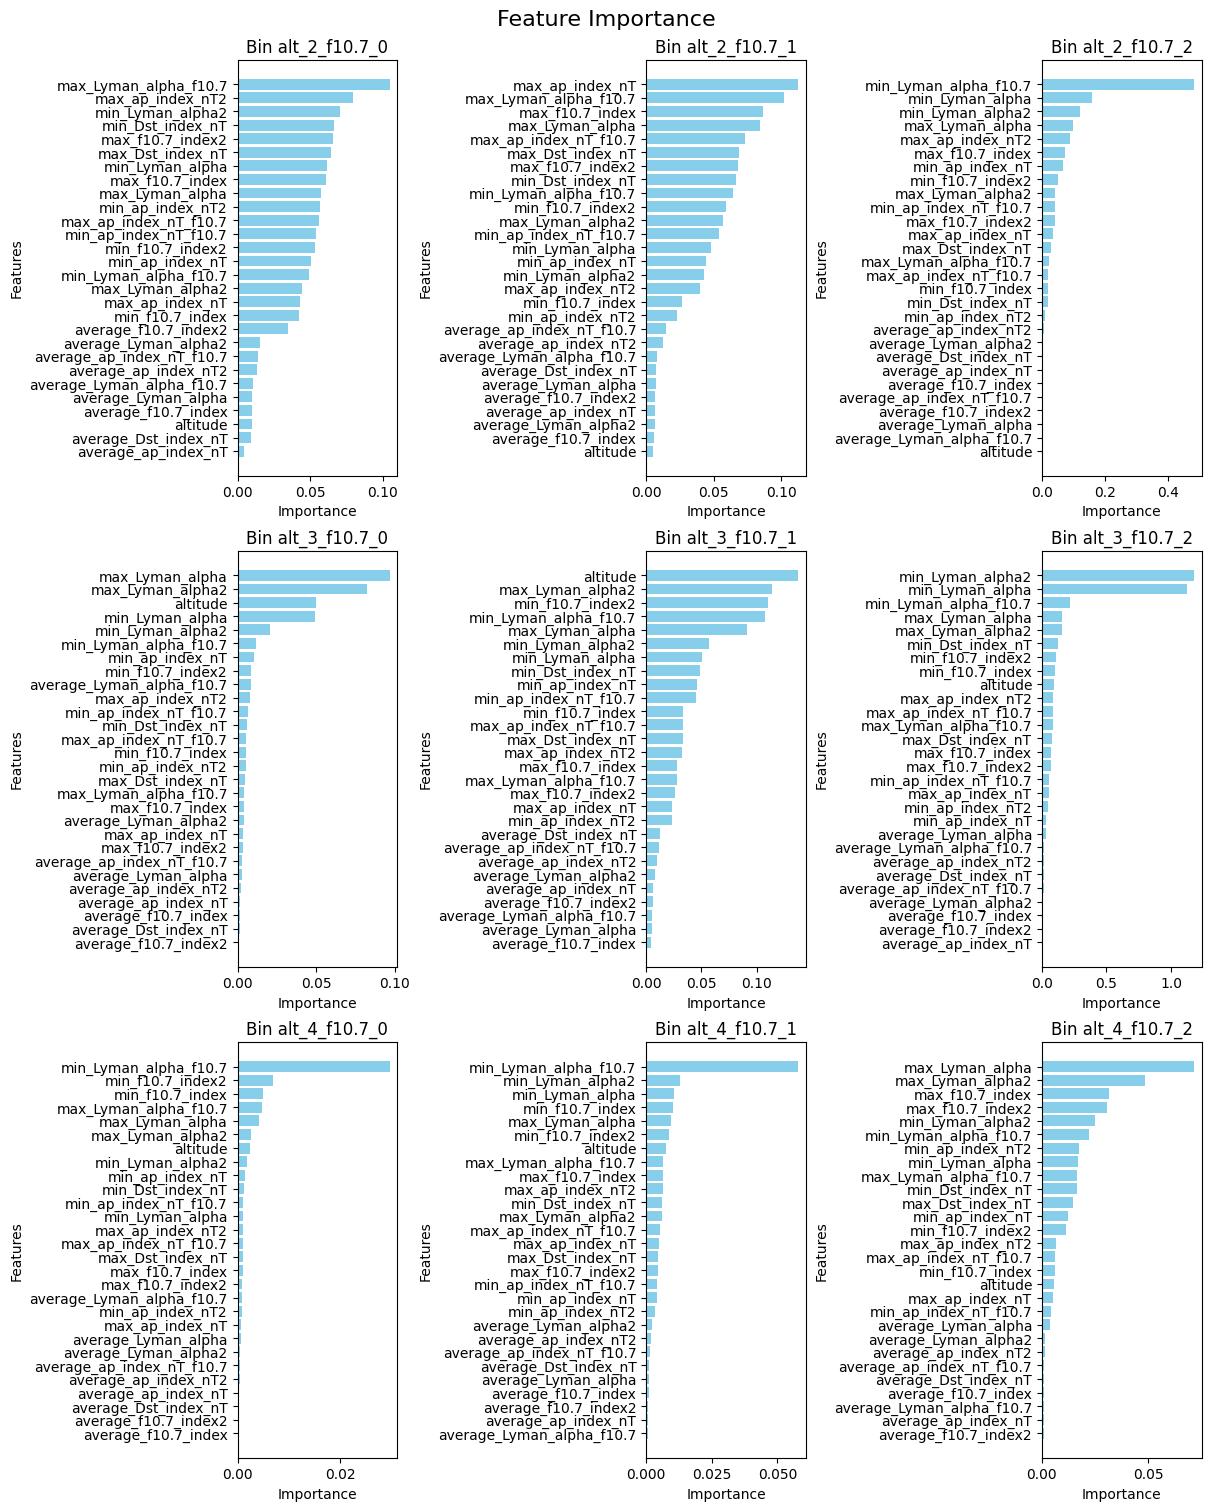

In [58]:
# Number of plots (one per bin that had data)
n_plots = len(rmse_log)

# Compute grid size (square-ish layout)
cols = math.ceil(math.sqrt(n_plots))
rows = math.ceil(n_plots / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 5 * rows), constrained_layout=True)

idx = -1 # initialize plot index

# Epochs
epochs = np.arange(0,100)

# Plot each training/validation loss curve
for i in range(len(alt_bins) - 1):
    # Skip first two altitude bins
    if i < 2:
        continue
    for j in range(len(solar_act_bins) - 1):
        idx += 1
        irow = idx//3
        jcol = idx%3
        ax = axes[irow][jcol]

        # Get feature list
        features = []
        proxy_prefix = ['average', 'min', 'max']
        proxy_vars = ['ap_index_nT', 'f10.7_index', 'Lyman_alpha', 'Dst_index_nT', 'Lyman_alpha2',
                      'f10.7_index2', 'Lyman_alpha_f10.7', 'ap_index_nT2', 'ap_index_nT_f10.7']
        
        for p in proxy_prefix:
            for f in proxy_vars:
                varname = '{}_{}'.format(p, f)
                features.append(varname)
        features += ['altitude']

        feature_importance = results[10 * i + j].get_booster().get_score(importance_type="gain")
        
        # Define a dictionary to replace feature names
        feature_name_mapping = {}
        
        for if_, f_ in enumerate(features):
            feature_name_mapping[f'f{if_}'] = features[if_]
        
        # Replace feature names using the dictionary
        updated_feature_importance = {
            feature_name_mapping.get(k, k): v for k, v in feature_importance.items()
        }
        
        # Sort updated features by importance
        sorted_features = sorted(updated_feature_importance.items(), key=lambda x: x[1], reverse=True)
        
        # Plot the updated feature importance
        features, importances = zip(*sorted_features)
        ax.barh(features, importances, color="skyblue")
        ax.set_xlabel("Importance")
        ax.set_ylabel("Features")
        ax.invert_yaxis()
        ax.set_title(f"Bin alt_{i}_f10.7_{j}")
        #ax.grid(True)

# Show the full figure
plt.suptitle("Feature Importance", fontsize=16)

plt.savefig('feature_importance_xgb_v11.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()